In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
import ast
from IPython.display import display
import numpy as np
import seaborn as sns

override_files = (list(Path('.').glob('**/overrides.yaml')))
df = pd.DataFrame()
for override_file in override_files:    
       
    factors = yaml.safe_load(override_file.read_text())
    factors = dict([elm.split('=') for elm in factors if elm[0] != '+'])
    
    factors = pd.DataFrame(factors,index=range(0,int(factors['epochs']))) #Factors df with a duplicate row per epoch
    factors['epoch'] = list(range(1,int(factors.epochs[0]) + 1 )) #Adding epoch number to each row
    
    log_file =  override_file.parent.parent /'TrainModel.log'
    with open(log_file) as f:
        metrics = [log.split("- ")[-1].strip().split(': ') for log in f.readlines() if '__main__' in log]
        metrics = pd.DataFrame({k:ast.literal_eval(v) for k,v in metrics}) #Metric df containing the log metrics
    
    #concat factor and metrics dfs to the final df
    df = pd.concat([df, pd.concat([factors, metrics],axis=1)])
    

In [6]:
df = df.rename(columns={'modelconf.layersconf.Random_Flip.mode':'Random_Flip', 'modelconf.layersconf.Random_Brightness.factor':'Random_Brightness', 'modelconf.layersconf.Random_Contrast.factor':'Random_Contrast'})
df.epoch = df.epoch.astype('uint8')
df.Random_Brightness = df.Random_Brightness.astype('float64')
df.Random_Contrast = df.Random_Contrast.astype('float64')
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9300 entries, 0 to 9299
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   modelconf            9300 non-null   object 
 1   Random_Flip          9300 non-null   object 
 2   Random_Brightness    9300 non-null   float64
 3   Random_Contrast      9300 non-null   float64
 4   epochs               9300 non-null   object 
 5   epoch                9300 non-null   uint8  
 6   Train Accuracy       7280 non-null   float64
 7   Train Loss           7280 non-null   float64
 8   Validation Accuracy  7280 non-null   float64
 9   Validation Loss      7280 non-null   float64
dtypes: float64(6), object(3), uint8(1)
memory usage: 663.1+ KB


In [7]:
desc = df[df.epoch > 6].groupby(['Random_Flip','Random_Brightness', 'Random_Contrast']).describe()
val_acc = desc['Validation Accuracy'].reset_index().sort_values('50%', ascending=False)
train_acc = desc['Train Accuracy'].reset_index().sort_values('50%', ascending=False)

In [8]:
val_acc.iloc[:6,:]

,Random_Flip,Random_Brightness,Random_Contrast,count,mean,std,min,25%,50%,75%,max
28,horizontal_and_vertical,0.0,0.3,84.0,0.760940,0.039463,0.662808,0.730373,0.766643,0.784732,0.841172
57,vertical,0.1,0.2,98.0,0.759085,0.034957,0.635673,0.734171,0.766281,0.782019,0.819826
33,horizontal_and_vertical,0.1,0.3,70.0,0.756290,0.044693,0.596237,0.737247,0.765919,0.787446,0.840449
52,vertical,0.0,0.2,98.0,0.754452,0.055817,0.534009,0.749367,0.765376,0.780210,0.823806
37,horizontal_and_vertical,0.2,0.2,56.0,0.750284,0.044848,0.635673,0.724584,0.763567,0.779215,0.834660
31,horizontal_and_vertical,0.1,0.1,70.0,0.750677,0.057713,0.507959,0.721418,0.761577,0.788531,0.856729


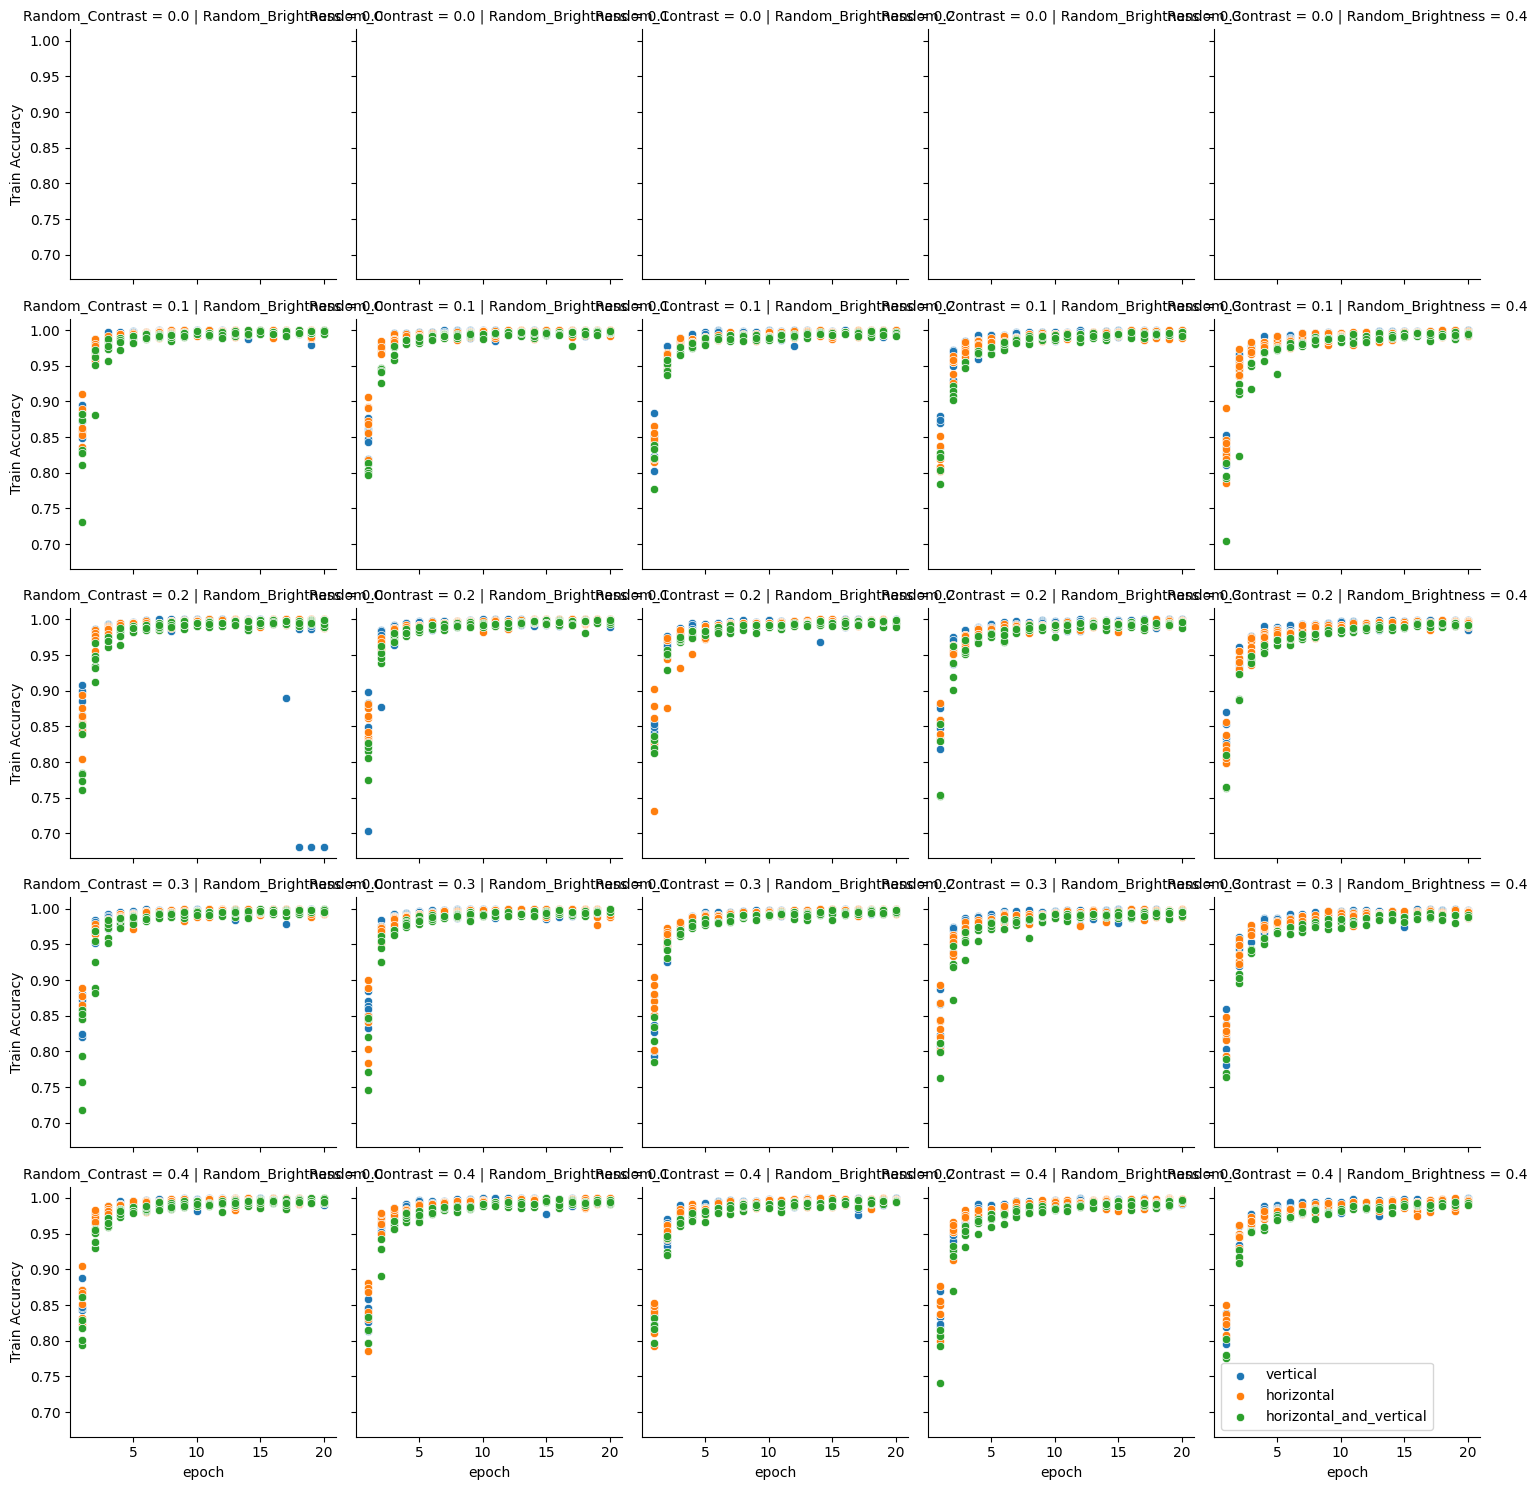

In [9]:
g = sns.FacetGrid(df, col = 'Random_Brightness', row = 'Random_Contrast', hue='Random_Flip')
g.map_dataframe(sns.scatterplot, x='epoch', y='Train Accuracy')
plt.tight_layout()
plt.legend()

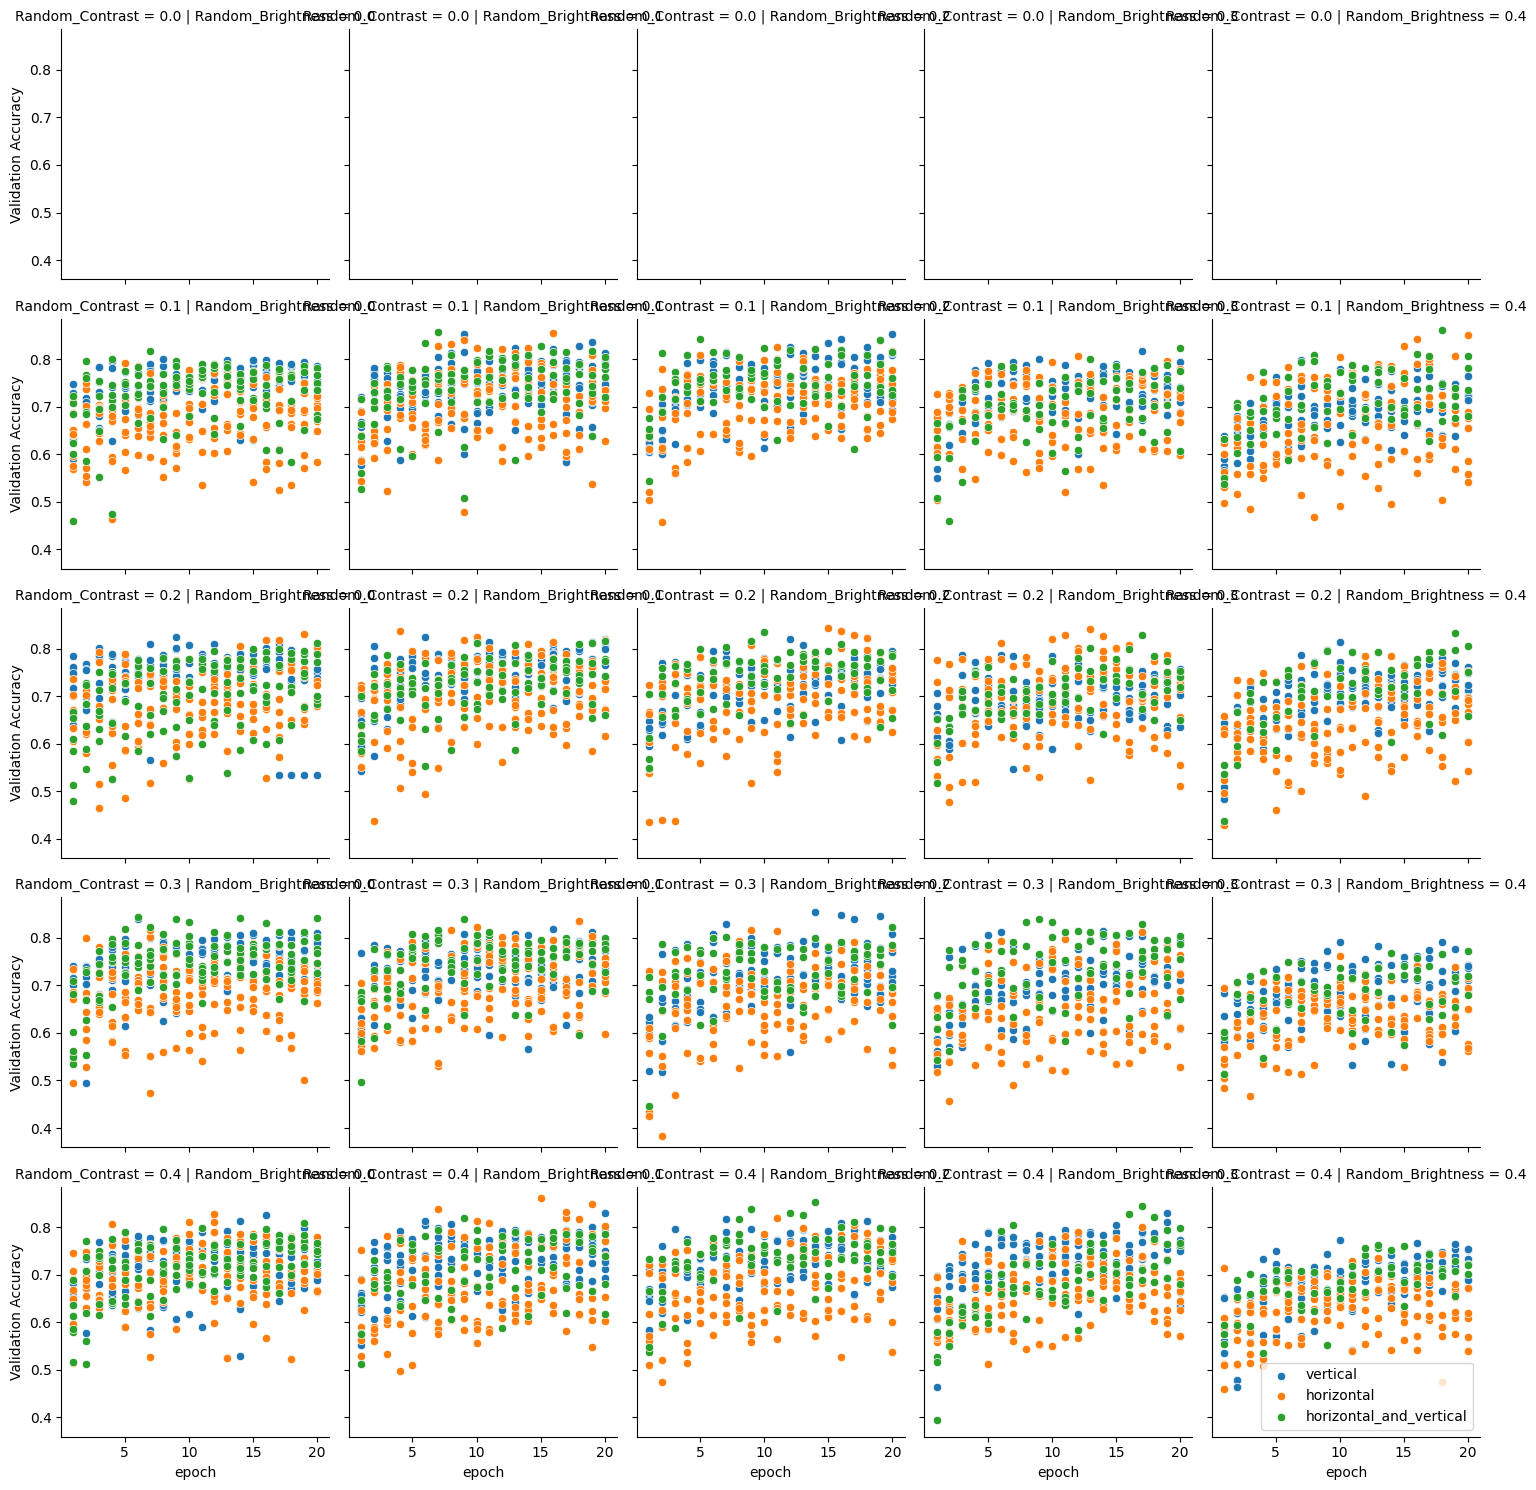

In [7]:
g = sns.FacetGrid(df, col = 'Random_Brightness', row = 'Random_Contrast', hue='Random_Flip')
g.map_dataframe(sns.scatterplot, x='epoch', y='Validation Accuracy')
plt.tight_layout()
plt.legend()

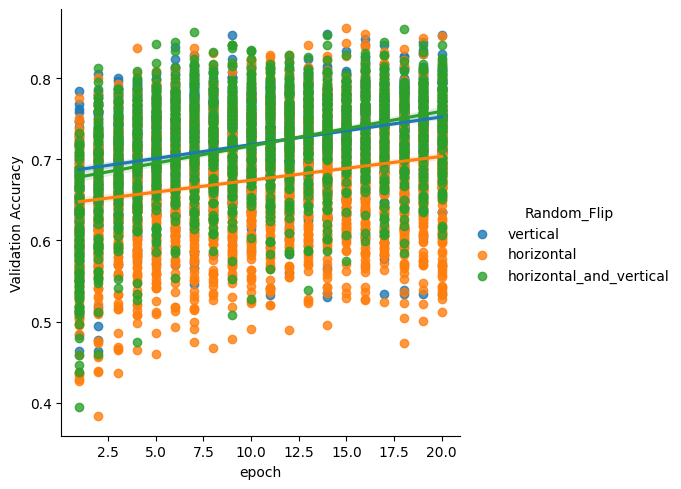

In [8]:
sns.lmplot(data=df,
           x='epoch',
           y='Validation Accuracy',
           hue='Random_Flip')

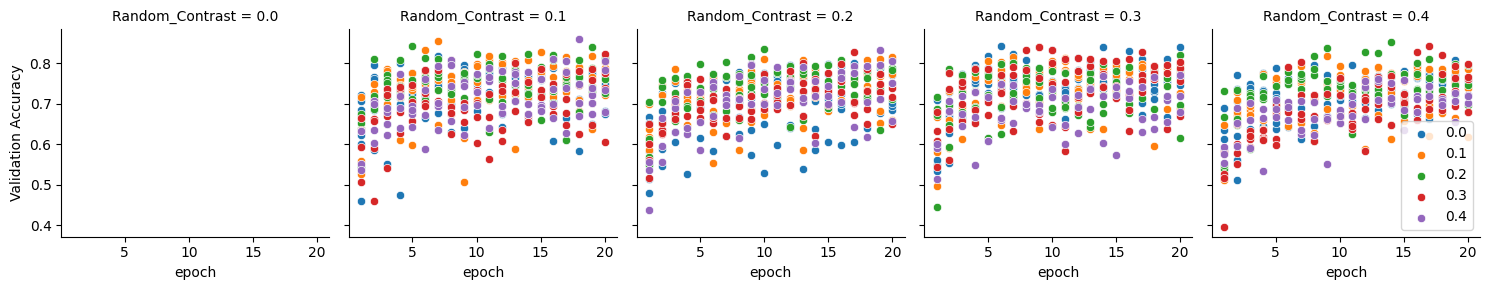

In [13]:
g = sns.FacetGrid(df[df.Random_Flip == 'horizontal_and_vertical'], col = 'Random_Contrast', hue='Random_Brightness')
g.map_dataframe(sns.scatterplot, x='epoch', y='Validation Accuracy')
plt.tight_layout()
plt.legend()